#Introduciton and Data Definitions

- **Value (C)**: Represents the current market value of an option. This is the price at which the option is trading in the market.

- **S**: Stands for the current value of the underlying asset that the option is based on. This could be the price of a stock, a commodity, an index, etc.

- **K**: Known as the strike price of the option. It's the predetermined price at which the holder of the option can buy (in the case of
 a call option) or sell (in the case of a put option) the underlying asset.

- **r**: Represents the annual interest rate. In financial models, this is often considered the risk-free rate, which is used to discount the future payoff of the option to present value.

- **tau (τ)**: Time to maturity of the option, expressed in years. It's the time left until the option's expiration date.

- **BS (Black-Scholes Formula)**: A mathematical model used to estimate the theoretical price of European-style options using current stock prices, expected dividends, the option's strike price, expected interest rates, time to expiration, and volatility. The formula was applied to this data to predict the option value, denoted as C_pred.

    - **C_pred - C**: The difference between the predicted option value (C_pred) and the current option value (C). This metric is used to evaluate the accuracy of the Black-Scholes model in predicting the current market value of an option.

    - **(Over)**: If an option has C_pred - C > 0, meaning the prediction overestimated the option value, it is associated with "Over". This indicates that the model's predicted price is higher than the market price.

    - **(Under)**: Conversely, if C_pred - C ≤ 0, meaning the prediction underestimated the option value or was exactly accurate, it is associated with "Under". This indicates that the model's predicted price is less than or equal to the market price.


## Preprocessing and basic EDA

Bellow I will be performing the following things:

- Checking for nulls
- Dropping unnesessary columns
- Checking the outliers
- Checking some some basic summary stats
- Correlation Matrix

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files, drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/DSO 530 Final Project/data/'
os.chdir(data_path)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## data read
option_train = pd.read_csv(data_path + 'option_train.csv')
option_test = pd.read_csv(data_path + 'option_test_nolabel.csv')
prediction = pd.read_csv(data_path + 'group_0_prediction.csv')

In [ ]:
#clean up dataframe for consistency
prediction=prediction.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']).rename(
    columns={'Unnamed: 0':'Value', 'Unnamed: 1':'BS'})[1:].reset_index(drop=True)
option_train.drop(columns=["Unnamed: 0"], inplace=True)
option_test.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
print(f"option_train shape: {option_train.shape}")
print(f"option_test shape: {option_test.shape}")
print(f"prediciton shape： {prediction.shape}")
option_train.columns

option_train shape: (5000, 6)
option_test shape: (500, 4)
prediciton shape： (500, 2)


Index(['Value', 'S', 'K', 'tau', 'r', 'BS'], dtype='object')

In [ ]:
# option_test.head(6)

In [ ]:
# option_train.head(6)

In [ ]:
print(option_train.isnull().sum())
print(option_test.isnull().sum())

# The dataset is cleaned and there are no null values.

Value    0
S        0
K        0
tau      0
r        0
BS       0
dtype: int64
S      0
K      0
tau    0
r      0
dtype: int64


In [ ]:
option_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   5000 non-null   float64
 1   S       5000 non-null   float64
 2   K       5000 non-null   int64  
 3   tau     5000 non-null   float64
 4   r       5000 non-null   float64
 5   BS      5000 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
#converting BS to binary value for better interpretability

option_train["BS_Binary"] = np.where(option_train["BS"] == 'Over', 1, 0)

In [ ]:
# # checking the distributing of 0s and 1s

# sns.countplot(x=option_train['BS_Binary'], color='k')
# plt.xlabel('Under                                                Over')
# plt.ylabel('Count')

# for i in range(len(option_train['BS_Binary'].value_counts())):
#     count = option_train['BS_Binary'].value_counts().values[i]
#     plt.text(i, count+10, str(count), ha='center')
# Descriptive statistics for numerical variables
print("Train data description:")
print(option_train.describe(),'\n')
# Similarly, describe test and prediction data

# Frequency/proportion of categorical variables
print("Value counts in train data:")
print(option_train['BS'].value_counts())
# Similarly, calculate value counts for other categorical variables and in other datasets


Train data description:
             Value            S            K          tau            r  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    140.316869  1426.643916  1370.244000     0.327615     0.011468   
std     125.155000    56.051523   172.679107     0.231184     0.000448   
min       0.281250  1264.740000   750.000000     0.084932     0.010600   
25%      45.750000  1387.670000  1275.000000     0.142466     0.011100   
50%     105.125000  1434.320000  1400.000000     0.238356     0.011400   
75%     200.406250  1469.440000  1475.000000     0.463014     0.011700   
max     685.500000  1527.460000  1995.000000     0.989041     0.012900   

         BS_Binary  
count  5000.000000  
mean      0.226400  
std       0.418543  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000   

Value counts in train data:
BS
Under    3868
Over     1132
Name: count, dtype: int64


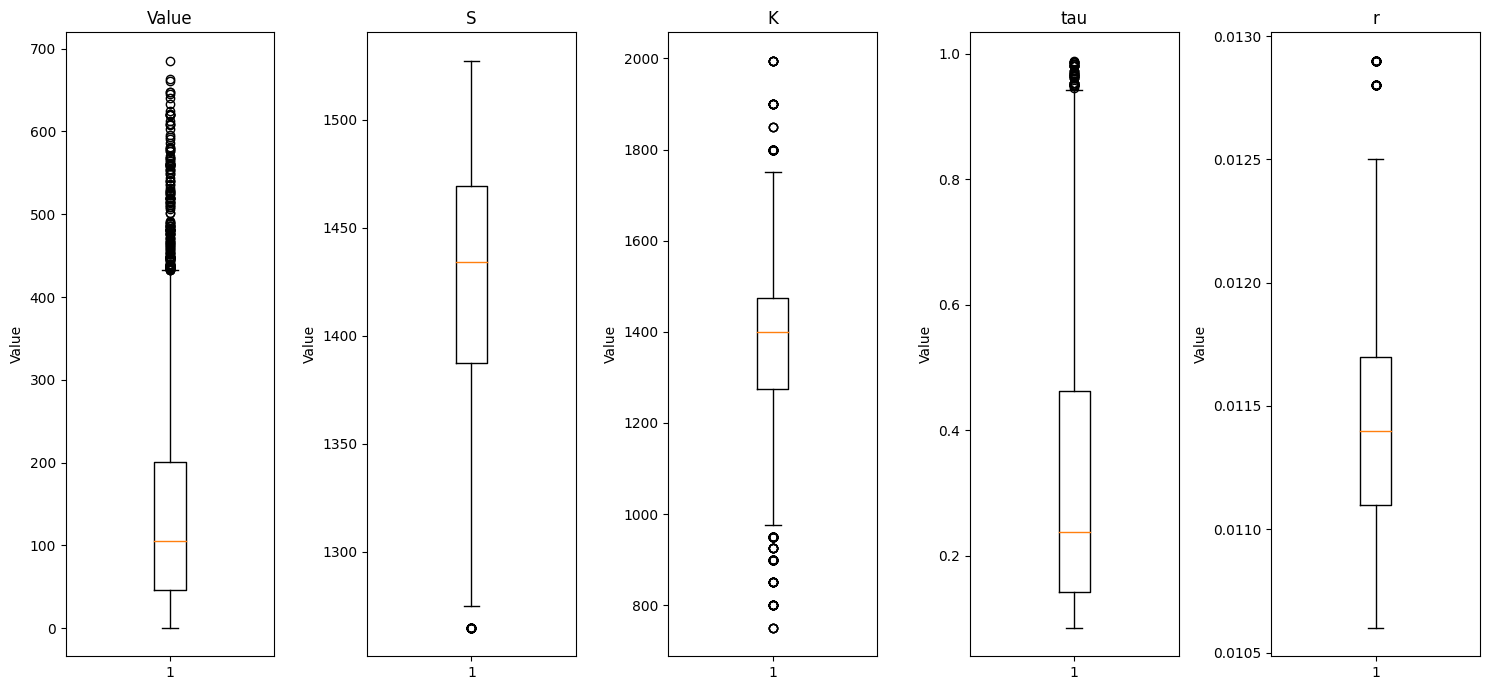

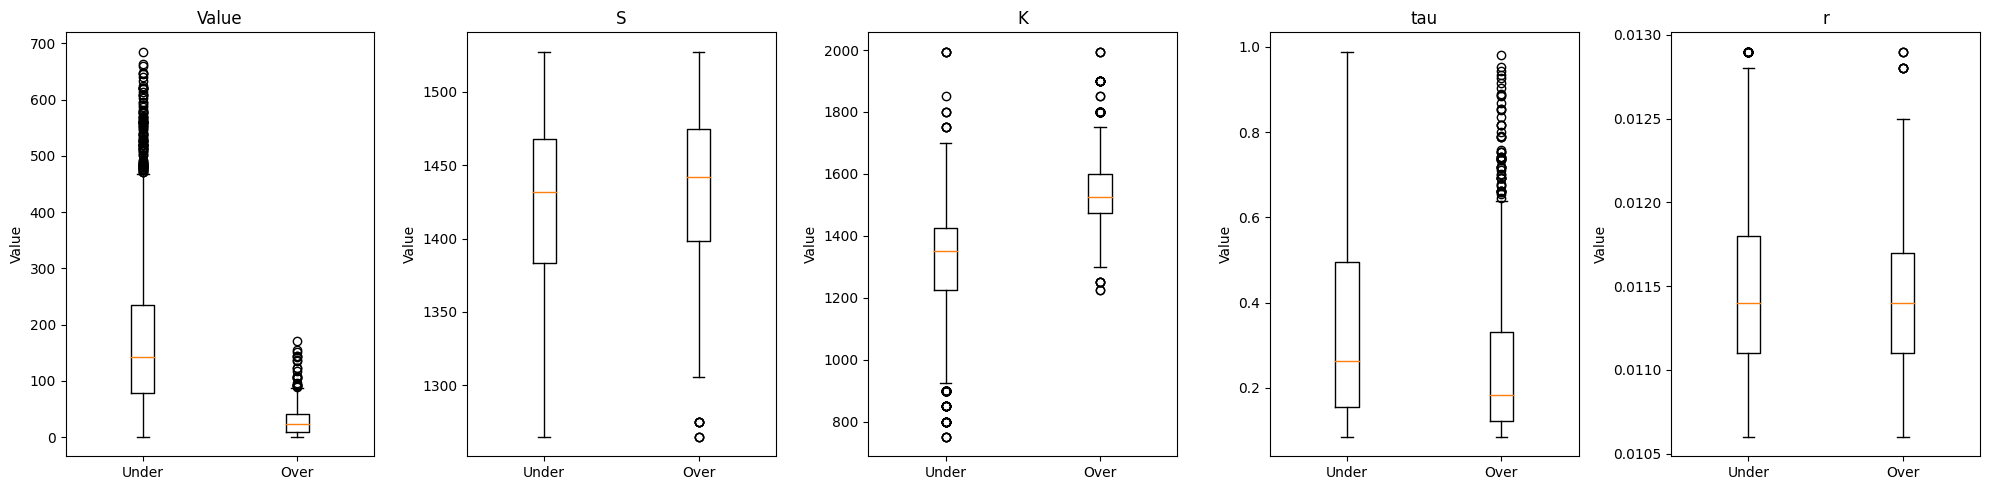

In [ ]:
# #checking the outliers to potenially perform Winsorization later
# for column in option_train.columns:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=option_train[column])
#     plt.title(f'Box Plot of {column}')
#     plt.ylabel('Values')
#     plt.show()
# Assuming your data is in a DataFrame called 'train_df'
columns_to_plot = ['Value', 'S', 'K', 'tau', 'r']

fig, axes = plt.subplots(1,5, figsize=(15, 7))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    axes[i].boxplot(option_train[column])
    axes[i].set_title(column)
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(20, 5))

for i, column in enumerate(columns_to_plot):
    under_data = option_train[option_train['BS'] == 'Under'][column]
    over_data = option_train[option_train['BS'] == 'Over'][column]

    axes[i].boxplot([under_data, over_data], labels=['Under', 'Over'])
    axes[i].set_title(column)
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

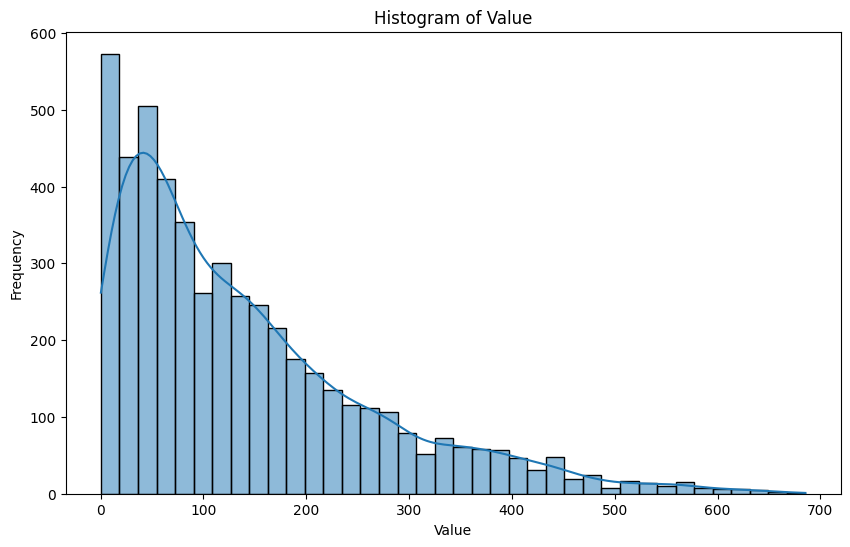

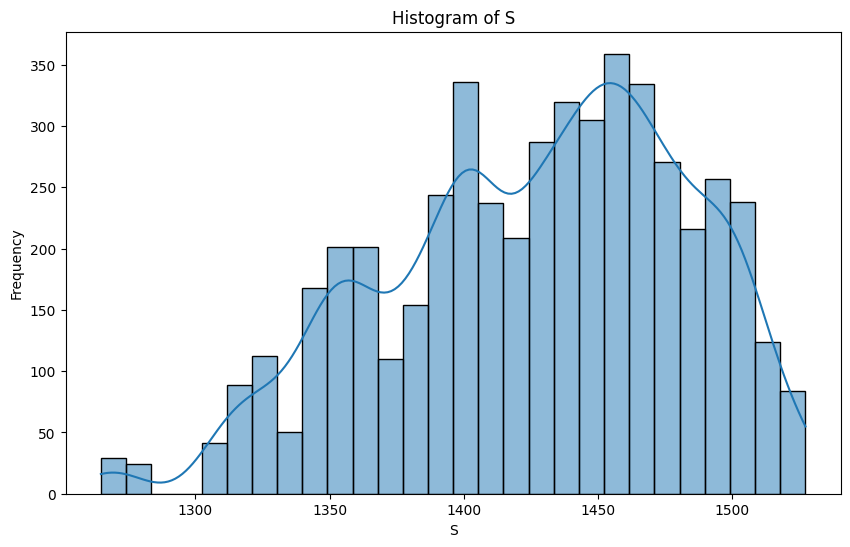

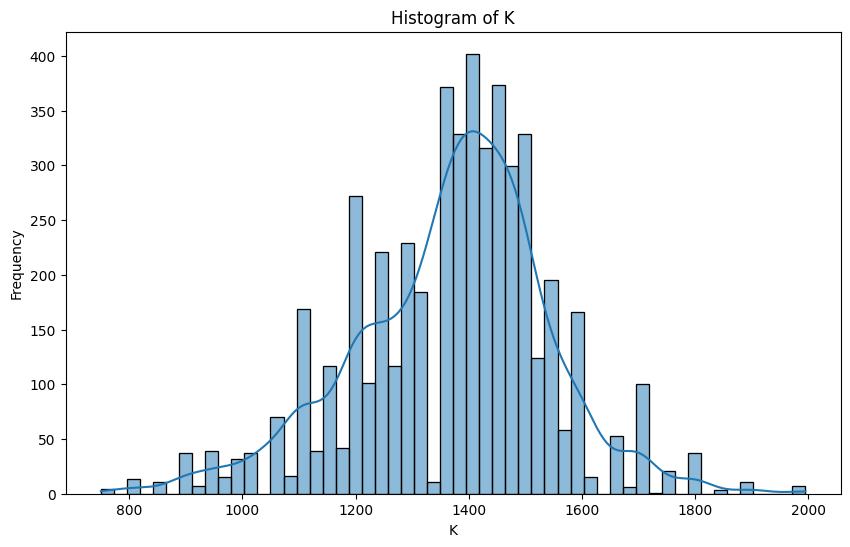

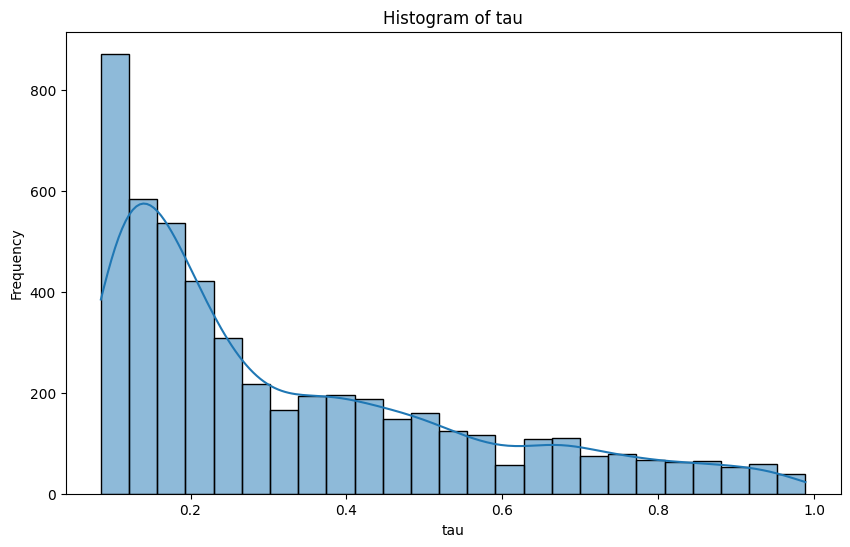

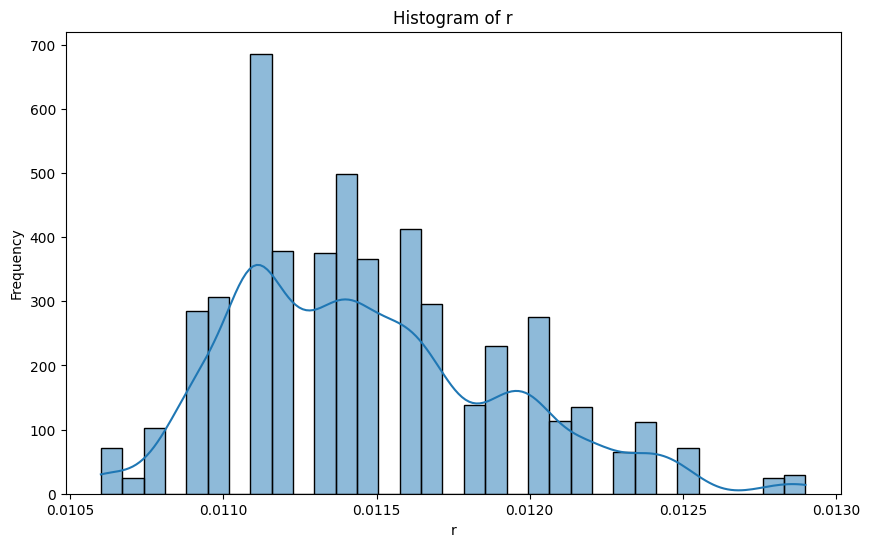

In [ ]:
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(option_train[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.ylabel('Frequency')
    plt.show()


### Basic statistics: Interpretation

- Value (C) Distribution shows some interesting results. The mean option value is $140.32, and a std of $125.16 indicate a super wide range of option values.

  - This wide range suggests significant variability in the option prices, which could be due to differences in the underlying asset prices (S), strike prices (K), or time to maturity (tau)

  - Outliers: The maximum option value is $685.50, which is significantly higher than the mean, which tells us about the presence of outliers

- Underlying Asset (S) and Strike Price (K) Comparison:

  - The mean values of S and K are relatively close (1426.64 and 1370.24, respectively), but the range of S is narrower than that of K. This proximity suggests that many options might be at-the-money (where S is close to K) or near-the-money

- Time to Maturity (tau):

  - The time to maturity ranges from approximately 0.08 years (about 29 days) to almost 1 year, with a mean of about 0.33 years (120 days).

------------------
Imporant one:
- BS_Binary (Classification of Over/Under):

  - The BS_Binary variable, which classifies options as either overestimated (1) or underestimated (0) by the Black-Scholes model, shows that a significant majority of options (about 77.36%) are classified as 'Under'. This could imply that the Black-Scholes model, as applied to your dataset, tends to underestimate option values, or it might reflect a specific characteristic of the options in the dataset (e.g., many options being out-of-the-money).

In [ ]:
########################################################################################################################

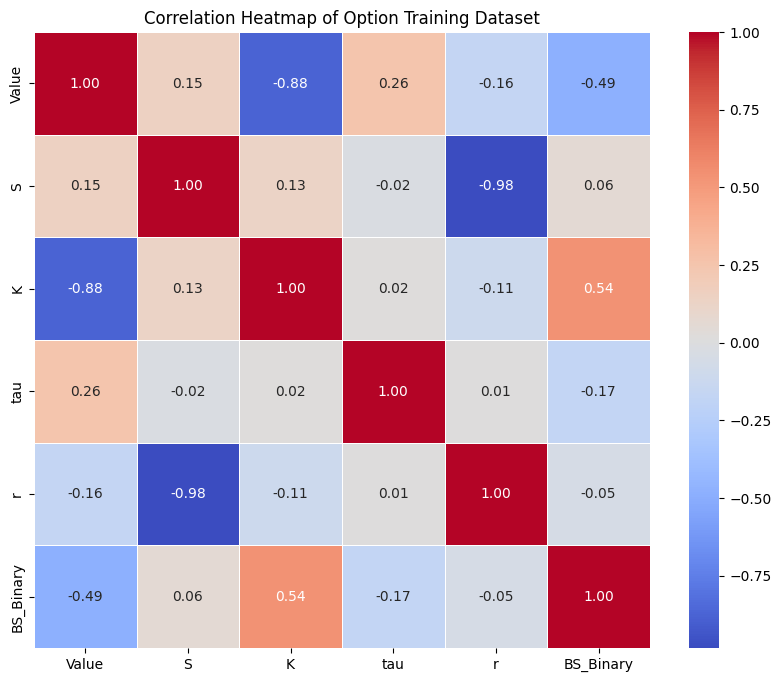

In [ ]:
# correlation matrix
option_train_1=option_train.drop(columns=["BS"])
corr_matrix = option_train_1.corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Heatmap of Option Training Dataset')
plt.show()

### Correlation Insights from Option Training Dataset

- `Value` and `K` (Strike Price) have a strong negative correlation (`-0.88`), indicating that as the strike price increases, the option value tends to decrease, which aligns with typical option pricing behavior.
- `S` (Current Asset Value) has a nearly zero correlation with `tau` (Time to Maturity) and `r` (Annual Interest Rate), suggesting these variables move independently of the asset value in the dataset.
- `r` (Annual Interest Rate) shows a very strong negative correlation with `BS_Binary` (`-0.98`), implying that lower interest rates may be associated with options being classified as overvalued by the Black-Scholes model.
- `K` (Strike Price) has a moderate positive correlation with `BS_Binary` (`0.54`), indicating that higher strike prices might lead to a higher chance of the option being classified as overvalued.
- The correlation between `Value` and `BS_Binary` is moderately negative (`-0.49`), suggesting that options with lower market values are more likely to be classified as overvalued by the Black-Scholes model.



In [ ]:
option_train.head(10)

,Value,S,K,tau,r,BS,BS_Binary
0,348.500,1394.46,1050,0.128767,0.0116,Under,0
1,149.375,1432.25,1400,0.679452,0.0113,Under,0
2,294.500,1478.90,1225,0.443836,0.0112,Under,0
3,3.375,1369.89,1500,0.117808,0.0119,Over,1
4,84.000,1366.42,1350,0.298630,0.0119,Under,0
5,163.000,1416.83,1275,0.178082,0.0114,Under,0
6,24.500,1445.57,1500,0.158904,0.0112,Over,1
7,210.500,1467.17,1275,0.180822,0.0111,Under,0
8,170.250,1464.92,1300,0.139726,0.0111,Over,1
9,164.000,1348.05,1300,0.800000,0.0120,Under,0


## Feature Engeneering

- The dataset seems to be pretty dry and small, but in this section I will attempt to create some new features that potentially could help us to improve our models' perfomance

In [ ]:
option_train_with_new_features = option_train.copy()

In [ ]:
option_train

,Value,S,K,tau,r,BS,BS_Binary
0,348.500,1394.46,1050,0.128767,0.0116,Under,0
1,149.375,1432.25,1400,0.679452,0.0113,Under,0
2,294.500,1478.90,1225,0.443836,0.0112,Under,0
3,3.375,1369.89,1500,0.117808,0.0119,Over,1
4,84.000,1366.42,1350,0.298630,0.0119,Under,0
...,...,...,...,...,...,...,...
4995,325.250,1465.15,1175,0.424658,0.0111,Under,0
4996,36.000,1480.87,1480,0.101370,0.0111,Over,1
4997,90.000,1356.56,1500,0.673973,0.0120,Under,0
4998,175.875,1333.36,1200,0.309589,0.0122,Under,0


In [ ]:
# S/K (Underlying Price to Strike Price Ratio): This ratio can be a critical determinant of an option's intrinsic value
# and its likelihood of being in or out of the money. It normalizes the asset's current price by the strike price,
# providing a relative measure of the option's moneyness without directly depending on the scale of the asset's price or strike price.

# moneyness feature
option_train_with_new_features['Moneyness'] = option_train_with_new_features['S'] / option_train_with_new_features['K']

# log moneyness - often used in options models
option_train_with_new_features['Log_Moneyness'] = np.log(option_train_with_new_features['Moneyness'])

# normalized Time to Maturity (assuming 252 trading days in a year)
option_train_with_new_features['Risk_free_rate_100'] = option_train_with_new_features['r'] * 100

# normalized time to maturity (assuming 252 trading days in a year)
option_train_with_new_features['Normalized_tau'] = option_train_with_new_features['tau'] * 252


In [ ]:
option_train_with_new_features['tau_short_term'] = (option_train_with_new_features['tau'] <= 0.142466) * 1  # Short term
option_train_with_new_features['tau_medium_term'] = ((option_train_with_new_features['tau'] > 0.142466) & (option_train_with_new_features['tau'] <= 0.463014)) * 1  # Medium term
option_train_with_new_features['tau_long_term'] = (option_train_with_new_features['tau'] > 0.463014) * 1  # Long term

In the dataset, the `tau` variable represents the time to maturity of options in years.
- The lines of code create binary features that categorize `tau` into three distinct time frames: short, medium, and long-term.
    - This categorization is based on the quantiles of `tau` derived from the dataset's distribution (25%, 50%, and 75%). The resulting binary variables (`tau_short_term`, `tau_medium_term`, and `tau_long_term`) take a value of 1 if the condition is met or 0 otherwise, which simplifies the modeling of non-linear relationships between time to maturity and option pricing.

-----
Not sure if we're going to end up using those feautures but for now ill keep them here


In [ ]:
option_train_with_new_features

,Value,S,K,tau,r,BS,BS_Binary,Moneyness,Log_Moneyness,Risk_free_rate_100,Normalized_tau,tau_short_term,tau_medium_term,tau_long_term
0,348.500,1394.46,1050,0.128767,0.0116,Under,0,1.328057,0.283717,1.16,32.449315,1,0,0
1,149.375,1432.25,1400,0.679452,0.0113,Under,0,1.023036,0.022774,1.13,171.221918,0,0,1
2,294.500,1478.90,1225,0.443836,0.0112,Under,0,1.207265,0.188358,1.12,111.846575,0,1,0
3,3.375,1369.89,1500,0.117808,0.0119,Over,1,0.913260,-0.090735,1.19,29.687671,1,0,0
4,84.000,1366.42,1350,0.298630,0.0119,Under,0,1.012163,0.012090,1.19,75.254795,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,325.250,1465.15,1175,0.424658,0.0111,Under,0,1.246936,0.220689,1.11,107.013699,0,1,0
4996,36.000,1480.87,1480,0.101370,0.0111,Over,1,1.000588,0.000588,1.11,25.545205,1,0,0
4997,90.000,1356.56,1500,0.673973,0.0120,Under,0,0.904373,-0.100513,1.20,169.841096,0,0,1
4998,175.875,1333.36,1200,0.309589,0.0122,Under,0,1.111133,0.105381,1.22,78.016438,0,1,0


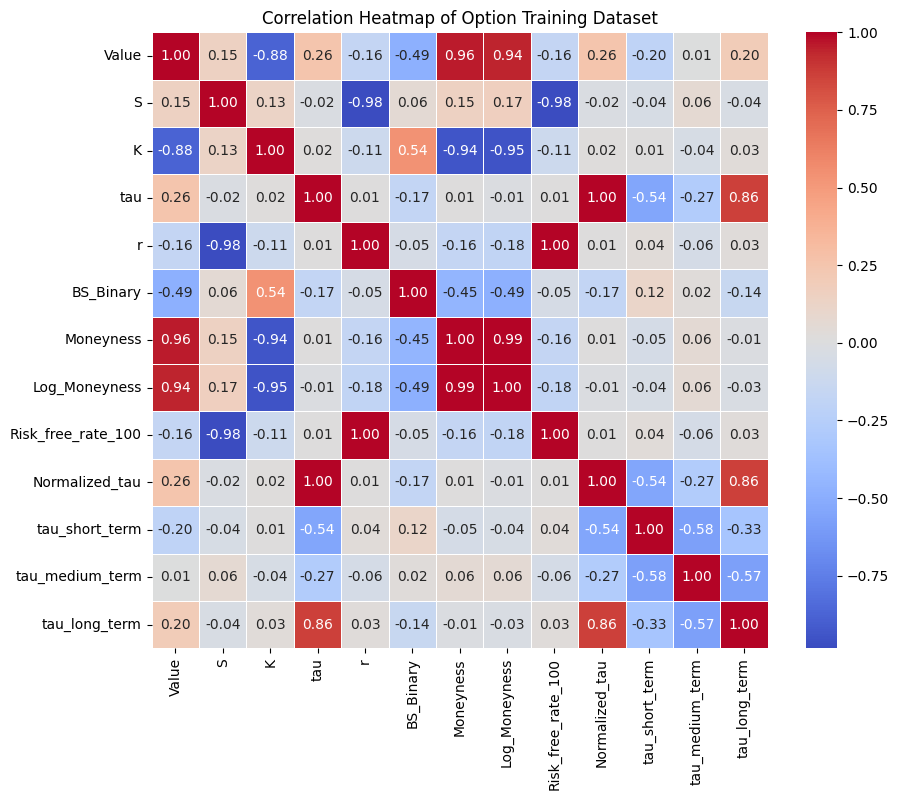

In [ ]:
#updated corr matrix
option_train_with_new_features_1=option_train_with_new_features.drop(columns=["BS"])
corr_matrix = option_train_with_new_features_1.corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Heatmap of Option Training Dataset')
plt.show()

### Some midway takeaways:

- The features Moneyness and Log_Moneyness are highly correlated with the Value (near or equal to 0.96 and 0.94 respectively), which suggests they are strong predictors for the option's market value. This makes sense, as Moneyness is a direct factor in option valuation.

- There is a strong negative correlation between Moneyness (and Log_Moneyness) and Strike Price (K), which is intuitive because as the strike price increases relative to the current asset price, the option becomes less valuable (out-of-the-money).

- The time to maturity categorization into short, medium, and long-term (tau_short_term, tau_medium_term, tau_long_term) shows a strong positive correlation with itself and a significant negative correlation between categories, as expected from mutually exclusive binary variables. However, they show a very high correlation with normalized_tau, which could lead to `multicollinearity` if used together in a model.

- The variable normalized_tau is also highly correlated with the original tau (0.86), which suggests that while it scales the feature, it might not add additional independent information.

## IMPORTANT NOTE

- at this stage I have two datasets: `option_train` and `option_train_with_new_features`
- i decided to split them up to see if new features actually contribute to the analysis

In [ ]:
option_train.head(4)

,Value,S,K,tau,r,BS,BS_Binary
0,348.500,1394.46,1050,0.128767,0.0116,Under,0
1,149.375,1432.25,1400,0.679452,0.0113,Under,0
2,294.500,1478.90,1225,0.443836,0.0112,Under,0
3,3.375,1369.89,1500,0.117808,0.0119,Over,1


In [ ]:
option_train_with_new_features.head(4)

,Value,S,K,tau,r,BS,BS_Binary,Moneyness,Log_Moneyness,Risk_free_rate_100,Normalized_tau,tau_short_term,tau_medium_term,tau_long_term
0,348.500,1394.46,1050,0.128767,0.0116,Under,0,1.328057,0.283717,1.16,32.449315,1,0,0
1,149.375,1432.25,1400,0.679452,0.0113,Under,0,1.023036,0.022774,1.13,171.221918,0,0,1
2,294.500,1478.90,1225,0.443836,0.0112,Under,0,1.207265,0.188358,1.12,111.846575,0,1,0
3,3.375,1369.89,1500,0.117808,0.0119,Over,1,0.913260,-0.090735,1.19,29.687671,1,0,0


## Dealing with Outliers

In this section I want to find an optimal way to deal with outliers. There are many different options how to deal with them, but I would consider the follwoing:
- Winsorization
- Imputations

Outlier' (ad nulls') imputation is a part of the hyperparameter tuning so I will do it after I run all the baseline models and evaluate their perfomance.

In [ ]:
#Winsorization is a statistical technique used to reduce the influence of outliers in a dataset.
# It involves replacing the extreme values in the data set with less extreme values, specifically
# the nearest values within the chosen limits.  This method is a way of managing outliers without
# completely removing them, thereby preserving the data's integrity to some extent.

## Data Splitting for Model Training and Evaluation


We prepare two versions of our dataset for analysis: the original dataset and an enhanced dataset with additional engineered features. For both datasets, we first exclude the target variable (`'Value'`) and categorical variables (`'BS'`, `'BS_Binary'`), and for the enhanced dataset, we further exclude dummy variables representing `tau` categorizations (`'tau_short_term'`, `'tau_medium_term'`, `'tau_long_term'`) to maintain only continuous variables for scaling.

The datasets are then split into training and testing sets using a 80-20 split

- **Original Dataset**: Used to establish a baseline performance metric.
- **Enhanced Dataset with New Features**: Used to assess the impact of feature engineering on model accuracy.



In [ ]:
#original dataset (option_train) standardization
# it's going to be called X_original

X_original = option_train.drop(['Value', 'BS', 'BS_Binary'], axis = 1)
Y_original = option_train['Value']

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, Y_original, test_size=0.2, random_state=42)


#dataset with all the new feautures:
X_new_features = option_train_with_new_features.drop(['Value', 'BS', 'BS_Binary', 'tau_short_term', 'tau_medium_term', 'tau_long_term'], axis = 1) # Note bellow
Y_new_features = option_train_with_new_features['Value']
'''
Dropping non-numeric and target columns but also dropping new dummy variables bc they aint continuous.
Applying StandardScaler to these dummies would distort this binary representation
'''
X_train_new_features, X_test_new_features, y_train_new_features, y_test_new_features = train_test_split(X_new_features, Y_new_features, test_size=0.2, random_state=42)



In [ ]:
#drop same feature in different scale for regression
option_train_with_new_features
X_new_features_reg = option_train_with_new_features.drop(['Value', 'BS', 'BS_Binary', 'tau_short_term',
                                                       'tau_medium_term', 'tau_long_term', 'Risk_free_rate_100', 'Normalized_tau'], axis = 1)
Y_new_features_reg = option_train_with_new_features['Value']
X_train_new_features_reg, X_test_new_features_reg, y_train_new_features_reg, y_test_new_features_reg = train_test_split(
    X_new_features_reg, Y_new_features_reg, test_size=0.2, random_state=42)

## Data Standardization

- Still thinking what how to standardize the data
  - StandardScaler?
  - MinMax?
  - Explore new/other methods?
  

In [ ]:
#Scaling the original dataset
scaler = StandardScaler()

X_train_original_scaled = scaler.fit_transform(X_train_original)
X_test_original_scaled = scaler.transform(X_test_original)


In [ ]:
#Scaling the new features dataset
scaler = StandardScaler()

X_train_new_features_scaled = scaler.fit_transform(X_train_new_features)
X_test_new_features_scaled = scaler.transform(X_test_new_features)

In [ ]:
#Scaling the new features dataset
scaler = StandardScaler()

X_train_new_features_scaled_reg = scaler.fit_transform(X_train_new_features_reg)
X_test_new_features_scaled_reg = scaler.transform(X_test_new_features_reg)

# Modeling

In this sections we're going to try out and build regressive several models such as the following:

- Linear Regression
- KNN Regression
- Random Forrest Regression
- Support Vector Regressor

Also we're going to perform several gradient boosting models:
- GradientBoostingRegressor

STILL BRAINSTORMING


## Linear Regression

In [ ]:
# Linear Regression Analysis for the original data
lr_model_original = LinearRegression()

#fitting the modell
lr_model_original.fit(X_train_original_scaled, y_train_original)

#predicting on the test set
y_pred_original = lr_model_original.predict(X_test_original_scaled)

#mse
mse_original = mean_squared_error(y_test_original,y_pred_original)
mae_original =  mean_absolute_error(y_test_original, y_pred_original)

print(mse_original)
print(mae_original)

1153.7489899704083
23.518296955180112


In [ ]:
#now runnin LRA on the df w/ new feautures

lr_model_new_features = LinearRegression()

# fitting the modell
lr_model_new_features.fit(X_train_new_features_scaled, y_train_new_features)
#predicting on the test set
y_pred_new_features = lr_model_new_features.predict(X_test_new_features_scaled)
#mse
mse_new_features = mean_squared_error(y_test_new_features, y_pred_new_features)
mae_new_features = mean_absolute_error(y_test_new_features, y_pred_new_features)

print(mse_new_features)
print(mae_new_features)

410.91173515256065
14.340566066712679


In [ ]:
#now runnin LRA on the df w/ new feautures

lr_model_new_features_reg = LinearRegression()

# fitting the modell
lr_model_new_features_reg.fit(X_train_new_features_scaled_reg, y_train_new_features_reg)
#predicting on the test set
y_pred_new_features_reg = lr_model_new_features_reg.predict(X_test_new_features_scaled_reg)
#mse
mse_new_features_reg = mean_squared_error(y_test_new_features_reg, y_pred_new_features_reg)
mae_new_features_reg = mean_absolute_error(y_test_new_features_reg, y_pred_new_features_reg)

print(mse_new_features_reg)
print(mae_new_features_reg)

410.76694674799376
14.336310513229666


In [ ]:
#############################################################################

In [ ]:
#doing the same analysis but using a statmodel.api packge to see the more verbosed version of an output

# Add a constant to the feature sets
X_train_original_sm = sm.add_constant(X_train_original_scaled)
X_train_new_features_sm = sm.add_constant(X_train_new_features_scaled)
X_train_new_features_sm_reg = sm.add_constant(X_train_new_features_scaled_reg)


# Fit the models using statsmodels
model_original = sm.OLS(y_train_original, X_train_original_sm).fit()
model_new_features = sm.OLS(y_train_new_features, X_train_new_features_sm).fit()
model_new_features_reg = sm.OLS(y_train_new_features_reg, X_train_new_features_sm_reg).fit()

print("Original Dataset Model Summary:")
print(model_original.summary())
print("\nNew Features Dataset Model Summary:")
print(model_new_features.summary())
print("\nNew Features Dataset Model Summary no dup:")
print(model_new_features_reg.summary())


Original Dataset Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 1.218e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        05:15:41   Log-Likelihood:                -19823.
No. Observations:                4000   AIC:                         3.966e+04
Df Residuals:                    3995   BIC:                         3.969e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.992

### Takeaways:

We compared the performance of linear regression models trained on two datasets: the original dataset and a dataset enhanced with new features.

### Original Dataset Model:
- **R-squared**: 0.924
  - The model explains 92.4% of the variance in the target variable, indicating a strong fit.
- **Significant Predictors**: Except for one predictor (`x4`), all others significantly contribute to the model (p < 0.05).
- **Model Complexity**: With only four predictors, the model is relatively simple.

### New Features Dataset Model:
- **R-squared**: 0.974
  - The enhanced model explains 97.4% of the variance, a noticeable improvement over the original dataset.
- **Significant Predictors**: The introduction of new features has led to some predictors (`x2`, `x5`, `x6`) having a significant impact on the model, while others (`x4`, `x7`) do not significantly contribute.
- **Model Complexity**: Increased to six predictors, excluding duplicates (`x4` and `x7` seem to be listed twice and share the same statistics, which might be a clerical error).

### Observations:
- **Improved Fit**: The inclusion of new features has led to a higher \(R^2\), indicating a better fit to the data.
- **Model Complexity vs. Performance**: The increase in model complexity (more predictors) has been justified by a substantial improvement in model fit.
- **Consideration of Overfitting**: While the model with new features performs better on this dataset, it's crucial to validate these results on an unseen test set to ensure that the model has not overfitted to the training data.

### Conclusion:
The analysis validates the hypothesis that adding carefully selected features can improve the predictive capability of a model. However, attention must be paid to feature selection to avoid overfitting and ensure model generalizability.

## KNN Regression

In [ ]:
#i will use the GridSearch to find the optimal K. An optimal range of potenial Ks is 1 through 20
# from sklearn.model_selection import GridSearchCV
# change scoring from mse to mae, which change the best K for the orginal dataset

param_grid = {'n_neighbors' : range(1,21)}

#next i'll need to run the GridSearchCV for both datasets
# im going to use a 5 fold cv

#--------------------------------------------------------------------------------------------------------------

#original dataset
knn = KNeighborsRegressor()
grid_search_orig = GridSearchCV(knn, param_grid, cv = 5, scoring ='neg_mean_absolute_error')
grid_search_orig.fit(X_train_original_scaled, y_train_original)

best_k_orig = grid_search_orig.best_params_['n_neighbors']
print(f"Best K for Original Dataset: {best_k_orig}")

#--------------------------------------------------------------------------------------------------------------

#dataset with new feautures
grid_search_new = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search_new.fit(X_train_new_features_scaled, y_train_new_features)

best_k_new = grid_search_new.best_params_['n_neighbors']
print(f"Best K for New Features Dataset: {best_k_new}")


Best K for Original Dataset: 5
Best K for New Features Dataset: 7


In [ ]:
#evaluation on the original dataset
knn_best_orig = KNeighborsRegressor(n_neighbors=best_k_orig)
knn_best_orig.fit(X_train_original_scaled, y_train_original)

predictions_orig = knn_best_orig.predict(X_test_original_scaled)
mse_orig = mean_squared_error(y_test_original, predictions_orig)
mae_orig = mean_absolute_error(y_test_original, predictions_orig)

# evaluation on the new features dataset
knn_best_new = KNeighborsRegressor(n_neighbors=best_k_new)
knn_best_new.fit(X_train_new_features_scaled, y_train_new_features)

predictions_new = knn_best_new.predict(X_test_new_features_scaled)
mse_new = mean_squared_error(y_test_new_features, predictions_new)
mae_new = mean_absolute_error(y_test_new_features, predictions_new)

print(f"MSE for Original Dataset: {mse_orig}")
print(f"MSE for New Features Dataset: {mse_new}")
print(f"MAE for Original Dataset: {mae_orig}")
print(f"MAE for New Features Dataset: {mae_new}")


MSE for Original Dataset: 217.66854125
MSE for New Features Dataset: 97.5719292490434
MAE for Original Dataset: 8.2947375
MAE for New Features Dataset: 6.611258928571427


In [ ]:
#also adding r^2s

r2_orig = r2_score(y_test_original, predictions_orig)
r2_new = r2_score(y_test_new_features, predictions_new)

print(f"R^2 for Original Dataset: {r2_orig}")
print(f"R^2 for New Features Dataset: {r2_new}")


R^2 for Original Dataset: 0.986369161192485
R^2 for New Features Dataset: 0.9938898509077413


Wrapping up today's session (April 1-2, 2024)

# (End of session 1) Next Steps:  

- Keep building all sorts of different models
  - Support Vector Regressor
  - Decision tree based
  - Random Forrests
  - Boosting and Gradient Boosting Models as well
- It seems like new features do have a positive impact so might as well think of some more features (optional)
- Use best subset selection (just because it was taught in class)

And the last part of the project will be classification :)


Date: April 2, 2024 -- Cont.

## Support Vector Analysis

In [ ]:
# C: The regularization parameter. A large value of C basically tells the model to give more importance to classifying all training points correctly,
#  which could lead to overfitting. Smaller values encourage a larger margin and smoother decision boundary at the cost of training accuracy.

# epsilon: This parameter specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within
#  a distance epsilon from the actual value. It controls the width of the margin of tolerance where no penalty is given to errors.

# kernel: Specifies the kernel type to be used in the algorithm. The kernel transforms the input data into a higher-dimensional space where a linear
#  separator can be found. Common choices are 'linear', 'poly' (polynomial), and 'rbf' (Radial Basis Function)

param_grid = {'C': [1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf']}


#original dataset grid search
grid_search_orig =  GridSearchCV(SVR(), param_grid, cv = 5, scoring='neg_mean_absolute_error', verbose=2)

grid_search_orig.fit(X_train_original_scaled, y_train_original)

best_params_orig = grid_search_orig.best_params_
print(f"Best parameters for Original Dataset: {best_params_orig}")
#Best parameters for Original Dataset: {'C': 1000, 'epsilon': 0.01, 'kernel': 'rbf'}

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   1.1s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   0.9s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   1.0s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   0.9s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   1.0s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.9s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.7s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.5s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.5s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.7s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   1.2s
[CV] END .....................C=1, epsilon=0.00

In [ ]:
#new feature dataset

# param_grid mentioned above

grid_search_new = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)
grid_search_new.fit(X_train_new_features_scaled, y_train_new_features)

best_params_new = grid_search_new.best_params_
print(f"Best parameters for New Features Dataset: {best_params_new}")
# mse: Best parameters for New Features Dataset: {'C': 1000, 'epsilon': 1, 'kernel': 'rbf'}
# mae: Best parameters for New Features Dataset: {'C': 1000, 'epsilon': 0.01, 'kernel': 'rbf'}

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   0.6s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   0.6s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   0.6s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   0.7s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   0.6s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.6s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.6s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   0.6s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   1.0s
[CV] END ....................C=1, epsilon=0.001, kernel=poly; total time=   1.0s
[CV] END .....................C=1, epsilon=0.001, kernel=rbf; total time=   1.2s
[CV] END .....................C=1, epsilon=0.00

In [ ]:
svr_best_orig = SVR(**best_params_orig)
svr_best_orig.fit(X_train_original_scaled, y_train_original)
predictions_orig_svr = svr_best_orig.predict(X_test_original_scaled)

svr_best_new = SVR(**best_params_new)
svr_best_new.fit(X_train_new_features_scaled, y_train_new_features)
predictions_new_svr = svr_best_new.predict(X_test_new_features_scaled)



#calculation
mse_orig_svr = mean_squared_error(y_test_original, predictions_orig_svr)
mae_orig_svr = mean_absolute_error(y_test_original, predictions_orig_svr)
r2_orig_svr = r2_score(y_test_original, predictions_orig_svr)

mse_new_svr = mean_squared_error(y_test_new_features, predictions_new_svr)
mae_new_svr = mean_absolute_error(y_test_new_features, predictions_new_svr)
r2_new_svr = r2_score(y_test_new_features, predictions_new_svr)

print(f"Original Dataset SVR - MSE: {mse_orig_svr}, MAE: {mae_orig_svr}, R^2: {r2_orig_svr}")
print(f"New Features Dataset SVR - MSE: {mse_new_svr}, MAE: {mae_orig_svr}, R^2: {r2_new_svr}")

#MSE results
# Original Dataset SVR - MSE: 52.19457186342105, R^2: 0.9967314716604803
# New Features Dataset SVR - MSE: 47.67411755032163, R^2: 0.997014551538375

#MAE results
# Original Dataset SVR - MSE: 48.22091018443431, MAE: 3.7185531180489497, R^2: 0.9969803102915052
# New Features Dataset SVR - MSE: 44.158182657496205, MAE: 3.7185531180489497, R^2: 0.9972347264038223

Original Dataset SVR - MSE: 48.22091018443431, MAE: 3.7185531180489497, R^2: 0.9969803102915052
New Features Dataset SVR - MSE: 44.158182657496205, MAE: 3.7185531180489497, R^2: 0.9972347264038223


### Takeaways

We evaluated the performance of Support Vector Regression (SVR) models on two versions of our dataset: the original dataset and a version enhanced with new features.

**Original Dataset Performance:**
- **Mean Squared Error (MSE)**: 52.19
- **R-squared (R^2)**: 0.997

**New Features Dataset Performance:**
- **Mean Squared Error (MSE)**: 47.67
- **R-squared (R^2)**: 0.997


## Gradient Boosting Model

Really solid article to learn the math behind GMB and XGBoost: [LINK](https://medium.com/analytics-vidhya/math-behind-gbm-and-xgboost-d00e8536b7de)


- Gradient Boosting Machines (GBM) are a ensemble learning technique that builds predictive models in a stage-wise fashion. It constructs a series of decision trees, where each tree is designed to correct the errors of its predecessor, effectively reducing bias and variance. By combining the predictions from multiple trees, GBM improves model accuracy and robustness, making it highly effective for a wide range of regression and classification problems.


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Shrinks the contribution of each tree
    'max_depth': [3, 4, 5],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 4],  # The minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # The minimum number of samples required to be at a leaf node
}



# original dataset
gbm = GradientBoostingRegressor()
grid_search_orig = GridSearchCV(gbm, param_grid, cv = 5, scoring = 'neg_mean_absolute_error', verbose = 2)
grid_search_orig.fit(X_train_original_scaled, y_train_original)
# Best parameters for original Features Dataset: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
# new features dataset
gbm = GradientBoostingRegressor()
grid_search_new = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)
grid_search_new.fit(X_train_new_features_scaled, y_train_new_features)
# Best parameters for New Features Dataset: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=2

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(f"Best parameters for original Features Dataset: {grid_search_orig.best_params_}")
print(f"Best parameters for New Features Dataset: {grid_search_new.best_params_}")

Best parameters for original Features Dataset: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best parameters for New Features Dataset: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# selected best params for the orig df
best_gbm_orig = GradientBoostingRegressor(**grid_search_orig.best_params_)
best_gbm_orig.fit(X_train_original_scaled, y_train_original)
predictions_orig_gbm = best_gbm_orig.predict(X_test_original_scaled)

# selected best params for the df with new features
best_gbm_new = GradientBoostingRegressor(**grid_search_new.best_params_)
best_gbm_new.fit(X_train_new_features_scaled, y_train_new_features)
predictions_new_gbm = best_gbm_new.predict(X_test_ne
w_features_scaled)
#calc
mse_orig_gbm = mean_squared_error(y_test_original, predictions_orig_gbm)
mae_orig_gbm = mean_absolute_error(y_test_original, predictions_orig_gbm)
r2_orig_gbm = r2_score(y_test_original, predictions_orig_gbm)


mse_new_gbm = mean_squared_error(y_test_new_features, predictions_new_gbm)
mae_new_gbm = mean_absolute_error(y_test_new_features, predictions_new_gbm)
r2_new_gbm = r2_score(y_test_new_features, predictions_new_gbm)

print(f"Original Dataset GBM - MSE: {mse_orig_gbm}, MAE: {mae_orig_gbm}, R^2: {r2_orig_gbm}")
print(f"New Features Dataset GBM - MSE: {mse_new_gbm}, MAE: {mae_new_gbm}, R^2: {r2_new_gbm}")

#mse result
# Original Dataset GBM - MSE: 37.84085777493336, R^2: 0.9976303299057083
# New Features Dataset GBM - MSE: 27.954009679727744, R^2: 0.9982494640806617

#mae result
# Original Dataset GBM - MSE: 37.99071026868526, MAE: 3.996864753424108, R^2: 0.9976209458432457
# New Features Dataset GBM - MSE: 25.926188962770244, MAE: 3.2622677479318956, R^2: 0.9983764502641711

Original Dataset GBM - MSE: 37.99071026868526, MAE: 3.996864753424108, R^2: 0.9976209458432457
New Features Dataset GBM - MSE: 25.926188962770244, MAE: 3.2622677479318956, R^2: 0.9983764502641711


Next Steps:
- XGBoost Models with optimized hyperparams
  - The model might take some time to run, especially with the gridsearchCV but it might lead to significantly improved results
  - The model above already achieved the r^2 of 99.8 which won't be easy to beat lmao
- LightGBM


In [ ]:
########################################################################################################################

****Classification****

In [ ]:
#KNN
#SVM
#GBM